### Exercises: Basic single-cell data analysis workflow 
In this exercise, we will import an example dataset, perform quality control steps, preprocess it, embed it into lower dimensional space and give cell type labels to clusters of cells.

#### Import required packages and data
We will use a subset of the 10x Genomics v3 10k PBMC dataset (“10k PBMCs from a Healthy Donor (v3 chemistry)”; https://www.10xgenomics.com/datasets/10-k-pbm-cs-from-a-healthy-donor-v-3-chemistry-3-standard-3-0-0). Cell numbers were reduced while keeping the individual cells’ sequencing depth the same. Only some cell types in the original dataset were kept. A number of empty droplets and low-quality cells are also included.

You need to download the dataset from the course github repository (https://github.com/buchauer-lab/charite-sc-data-course/blob/main/materials/Day2/healthy_PBMCs.zip), unzip it, and use the correct path to the data on your system in the import function below.

In [1]:
# general data handling
import numpy as np
import pandas as pd
from scipy import sparse

# single cell analysis
import scanpy as sc
import decoupler as dc

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# adjust the path to the location of the folder "healthy_PBMCs" on your system
pbmc_data_path = '/Users/libuchauer/Projects/charite-sc-data-course/materials/Day2/healthy_PBMCs/'

In [3]:
# import single cell data
adata = sc.read_10x_mtx(pbmc_data_path)

In [4]:
# basic information about the object is displayed if you enter 'adata' and execute the cell
adata

AnnData object with n_obs × n_vars = 2700 × 33538
    var: 'gene_ids', 'feature_types'

In [5]:
# documentation of anndata objects is here https://anndata.readthedocs.io/en/stable/
# inspect the count matrix adata.X
adata.X

<Compressed Sparse Column sparse matrix of dtype 'float32'
	with 5682040 stored elements and shape (2700, 33538)>

In [6]:
# inspect the gene names
adata.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.4', 'AL732372.1', 'OR4F29', 'AC114498.1',
       ...
       'AC007325.2', 'BX072566.1', 'AL354822.1', 'AC023491.2', 'AC004556.1',
       'AC233755.2', 'AC233755.1', 'AC240274.1', 'AC213203.1', 'FAM231C'],
      dtype='object', length=33538)

In [7]:
# inspect the cell identifiers
adata.obs_names

Index(['AAACGAAAGACGTCGA-1', 'AAAGAACAGTTCCGTA-1', 'AAAGAACGTTTGTTGG-1',
       'AAAGGATGTCGGTGAA-1', 'AAAGGATGTGTGGTCC-1', 'AAAGGATTCATTGTTC-1',
       'AAAGGATTCTGCGGGT-1', 'AAAGGATTCTTTGCAT-1', 'AAAGGGCCACGTCGTG-1',
       'AAAGGGCTCTTCCACG-1',
       ...
       'TTTGGAGAGAGCCATG-1', 'TTTGGAGAGAGTGTTA-1', 'TTTGGAGGTAATGTGA-1',
       'TTTGGAGGTATGCTAC-1', 'TTTGGAGGTCAAGCCC-1', 'TTTGGAGGTTTCACAG-1',
       'TTTGGAGTCTCGACGG-1', 'TTTGGTTAGGACACTG-1', 'TTTGGTTTCCTCCACA-1',
       'TTTGTTGTCCAAGCCG-1'],
      dtype='object', length=2700)

#### Questions
1. How many cells does the object contain? What do the names of the cells represent?
2. How many genes have been recorded?

### Quality control
Before getting started, recap with your neighbor what we discussed in the lectures:
1. Which kind of quality issues could our data suffer from?
2. Which metrics can we inspect to identify problematic cells?  

Now, we will begin by calculating the fraction of mitchondrial reads per cell. Mitochondrial gene names start with "MT-" for human, a pattern we can use to find the relevant genes.

In [8]:
# we first introduce a flag (True or False) value for each gene indicating whether it is mitochondrial
adata.var["mt"] = adata.var_names.str.startswith("MT-")

In [9]:
# use the function sc.pp.calculate_qc_metrics to calculate QC metrics including ones on mitochondrial genes
# use flag inplace=True
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True, log1p=True)

Which other QC metrics does the function calculate autoamtically? Visit the documentation to find out.

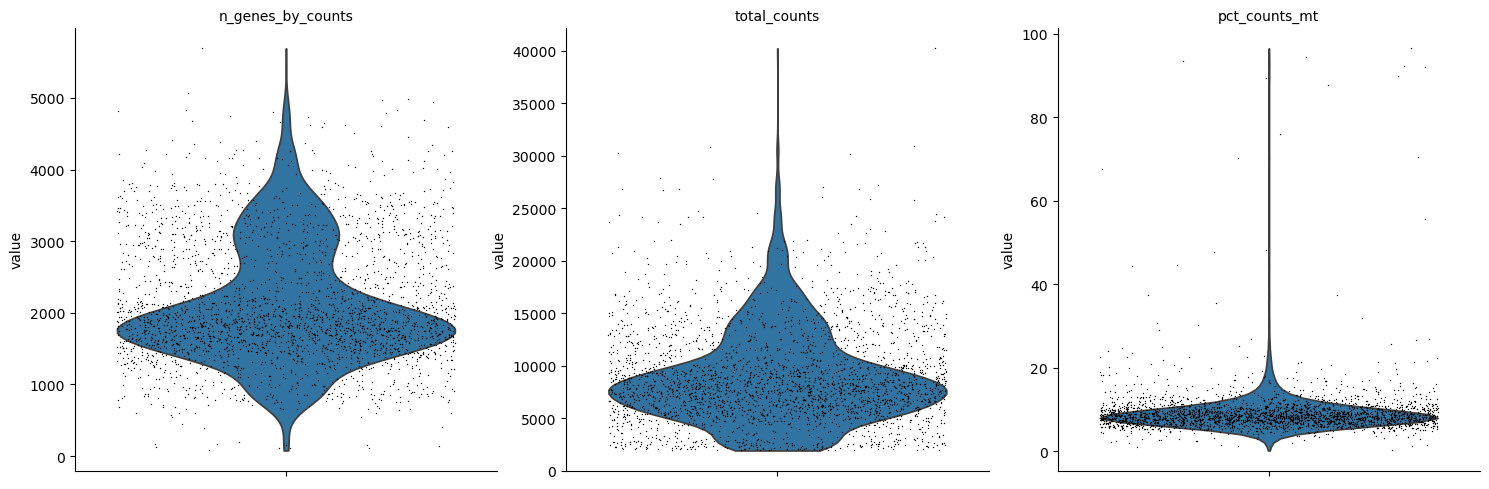

In [11]:
# plot violin plots of number of counts per cell, number of genes per cell
# and percentage of mitochondrial reads per cell using sc.pl.violin
# use flag multi_panel=True to get three separate panels
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

Discuss the shapes of these distribution with your neighbor. Which features of these distributions are of particular interest? Are there intuitive cut-offs that come to mind? 

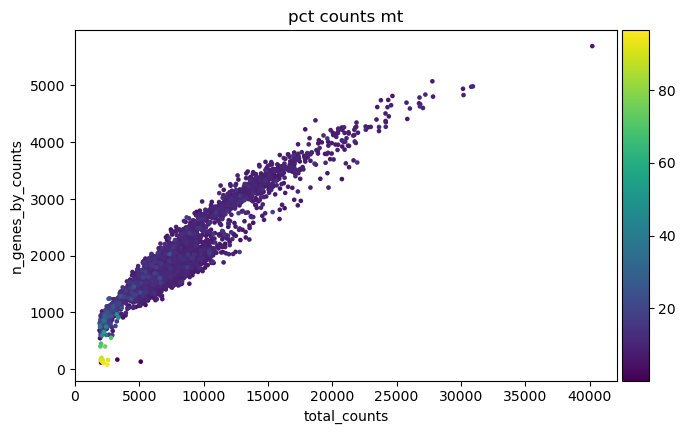

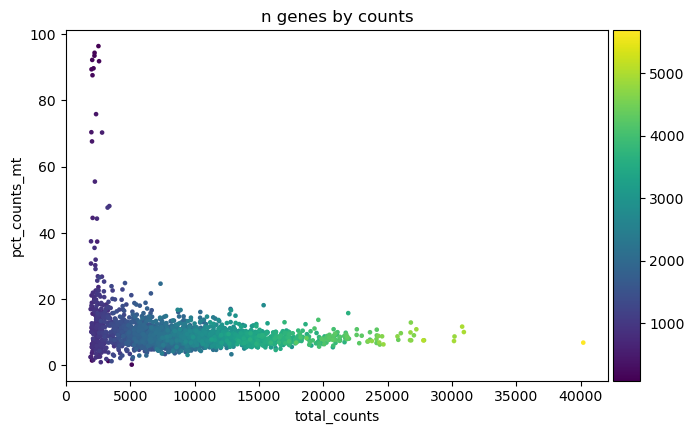

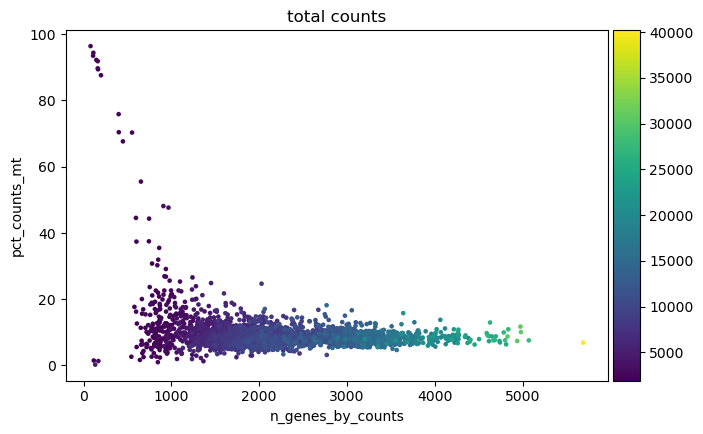

In [12]:
# inspect if there is a correlation between transcript counts and the number of recorded features
# as well as with the mitochondrial percentage
# use sc.pl.scatter to show total_counts, n_genes_by_counts and pct_counts_mt in one plot
# generate three plots, one with each pair of the three QC metrics on the axes
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
plt.show()
sc.pl.scatter(adata, "total_counts", "pct_counts_mt", color="n_genes_by_counts")
plt.show()
sc.pl.scatter(adata, "n_genes_by_counts", "pct_counts_mt", color="total_counts")

Text(0.5, 1.0, 'QC Metrics Correlation Matrix')

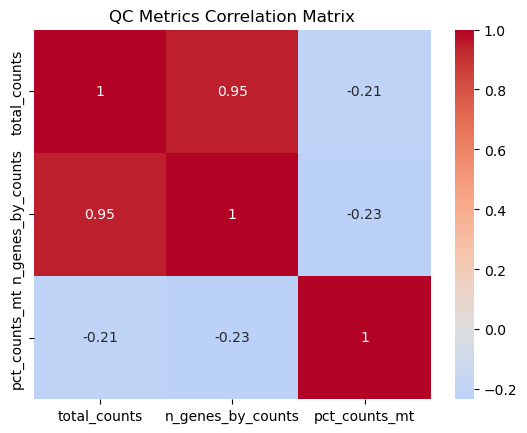

In [13]:
# Run this cell to have a quick look at the Pearson correlation coefficients between the QC metrics
qc_metrics = ['total_counts', 'n_genes_by_counts', 'pct_counts_mt']
correlation_matrix = adata.obs[qc_metrics].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('QC Metrics Correlation Matrix')

#### Questions
1. Is there a correlation between the number of counts per cell and the number of genes per cell? Why (not)?
2. Is there a correlation between the number of recorded genes per cell and the mitochondrial content? Why (not)?
3. What can we learn about cells with high mitochondrial content from all the plots we have generated until here?

We now need to decide on QC cut-offs for filtering, i.e. values for each of the QC metrics below (or above) which we will discard cells from the dataset. Generally, we advise you to be conservative at this stage in order to prevent losing too many cells. You can always add additional filtering steps later on.   
  
4. Keeping this advice in mind, decide on the following cut-offs:  
- minimum n_genes_by_counts   
- maximum n_genes_by_counts  
- maximum pct_counts_mt  

In [14]:
# apply the gene number filters to the data using sc.pp.filter_cells
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_cells(adata, max_genes=2500)
# modify the below funcion to include your mitochondrial cutoff
adata = adata[adata.obs.pct_counts_mt < 20]

In [15]:
# we will also remove genes which appear in less than 5 cells in order to reduce dataset size
sc.pp.filter_genes(adata, min_cells=5)

/opt/homebrew/Caskroom/miniforge/base/envs/scrnaseq/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


In [16]:
# how many cells did we lose through this filtering?
adata

AnnData object with n_obs × n_vars = 1923 × 14395
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

### Normalisation and identification of variable features
Following the lecture on data preprocessing, we will now normalize and logarithmize the data and will select highly variable features. We will also explore Pearson's reasiduals and compare the result to lognorm-preprocessing.

In [18]:
# unlike Seurat, which saves intermediate processed data layers per default, 
# processing steps in scanpy overwrite the orginial data. Therefore, we store
# the orginal count data in a separate data layer prior to proceeding
adata.layers["counts"] = adata.X.copy()
# we will also make a copy to be used in alternative processing with Pearson residuals below
adata2 = adata.copy()

In [19]:
# next, use scanpy's normalize_total to normalize each cell to 10.000 counts
sc.pp.normalize_total(adata, target_sum=1e4)

In [20]:
# use scanpy's log1p to log-transform the data
sc.pp.log1p(adata)

In [21]:
# run scanpy's highly_variable_genes to find the top 2000 variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

### Principal Component Analysis
We will calculate the principal components of our data (using the highly variable genes identified above as an input) and then inspect our data in the first few components - a first step towards cell type identification!

In [22]:
# run scanpys pca function on the data
sc.tl.pca(adata)

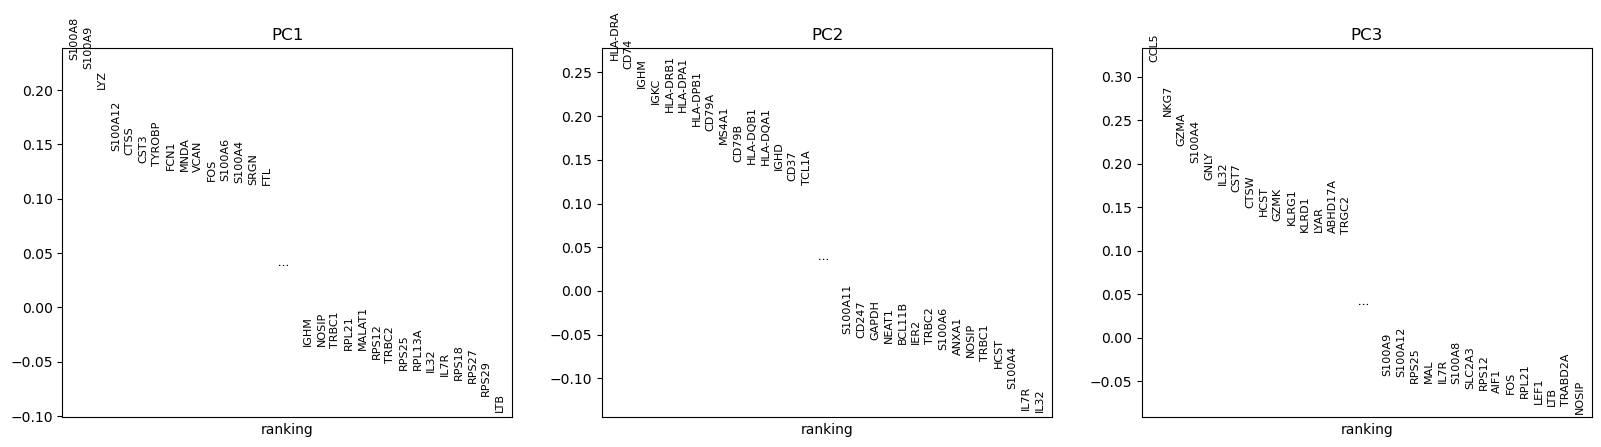

In [23]:
# use scanpy's plotting function pca_loadings to display the loadings of the  first 3 principal components
sc.pl.pca_loadings(adata, 
                   components=[1, 2, 3], 
                   include_lowest=True
    )

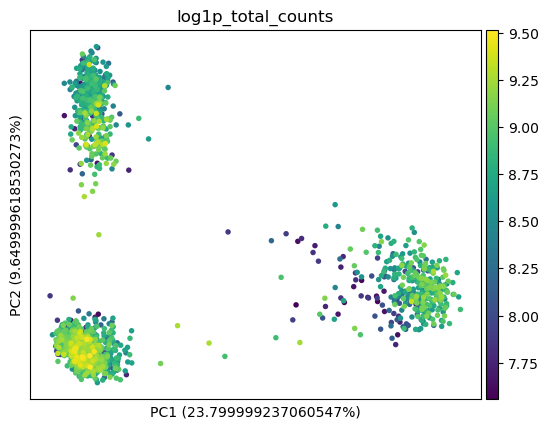

In [24]:
# plot a a 2D scatter plot of the dataset in its first two principal components using 
# scanpy's pca plot function. Colour the points by log1p_total_counts.
# use annotate_var_explained=True
sc.pl.pca(adata, color='log1p_total_counts', annotate_var_explained=True)

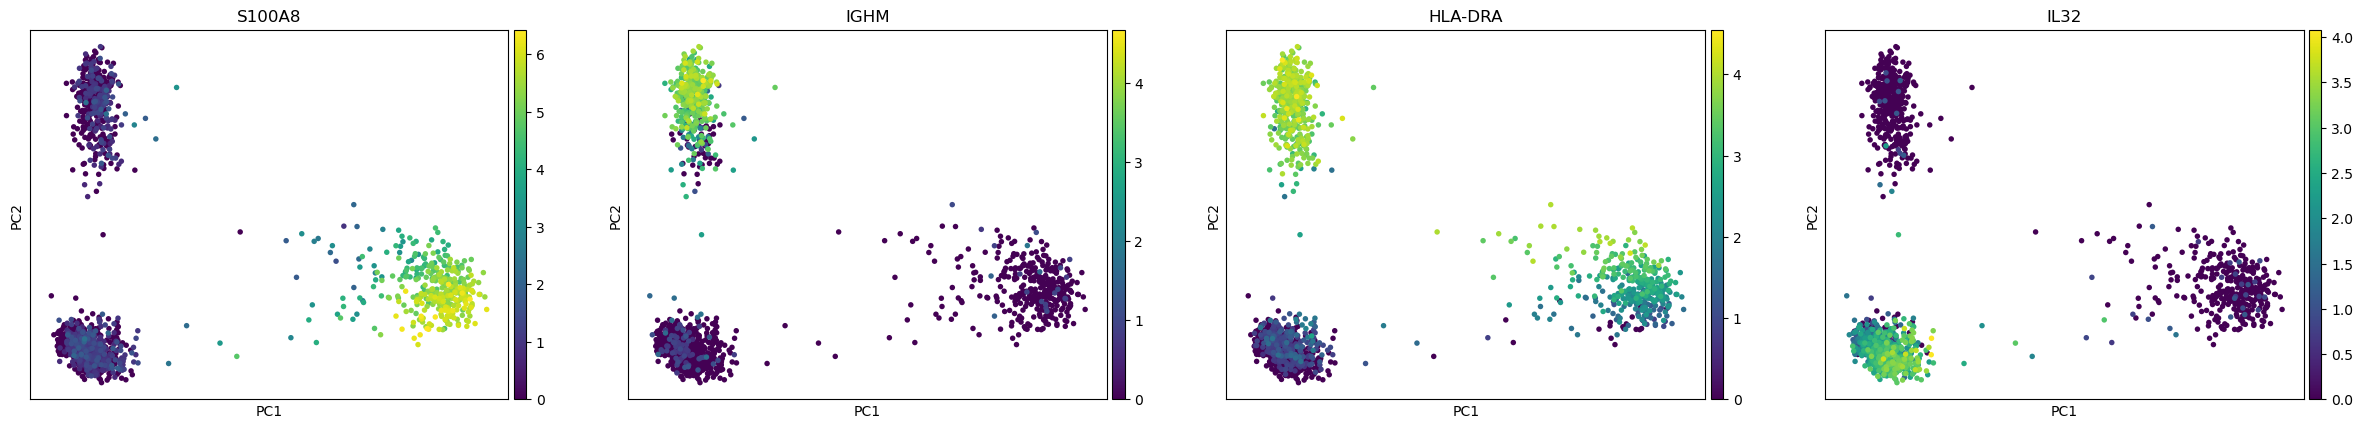

In [25]:
# make the same 2D PCA plot as above, but use the top positive and
# negative loading genes for PCs 1 and 2 to colour the dots
# (should result in 4 panels, one per gene).
sc.pl.pca(adata, color=['S100A8', 'IGHM', 'HLA-DRA', 'IL32'])

#### Questions
1. How much variability is contained in PC1, PC2 and PC3?
2. What is the biological interpretation of genes with positive vs. negative loadings on the same principal component? What does it mean when genes have opposite signs in their PC loadings?
3. Using PC1 and PC2 as an example, explain what biological processes or cell states might be represented by the positive vs. negative gene sets.
4. Looking at the 2D PCA plot above, there seem to be 3 main groups of cells separated by PCs 1 and 2. Based on the loading information, make an intelligent guess which cell types these might represent (you might search for the relevant genes online or ask a Chatbot of your choice).

### Alternative preprocessing with Pearson residuals [optional]
Pearson residuals, as introduced in the lecture, represent an alternative preprocessing strategy which can provide advantages for the identification of small populations. It is important to note that Pearson residuals _replace_ lognorm transformation and are not be used on top of them. Their computation requires raw counts as an input.

In [26]:
# use the unprocessed copy ot the anndata object made above and 
# transform it using sc.experimental.pp.normalize_pearson_residuals
sc.experimental.pp.normalize_pearson_residuals(adata2)

In [27]:
# we will also calculate highly variable genes based on Pearson residuals
# of note, this function expects raw counts as input, which we here provide via the corresponding layer
sc.experimental.pp.highly_variable_genes(adata2, flavor='pearson_residuals', n_top_genes=2000, layer='counts')

In [28]:
# calculate a pca for the Pearson transformed dataset
sc.tl.pca(adata2)

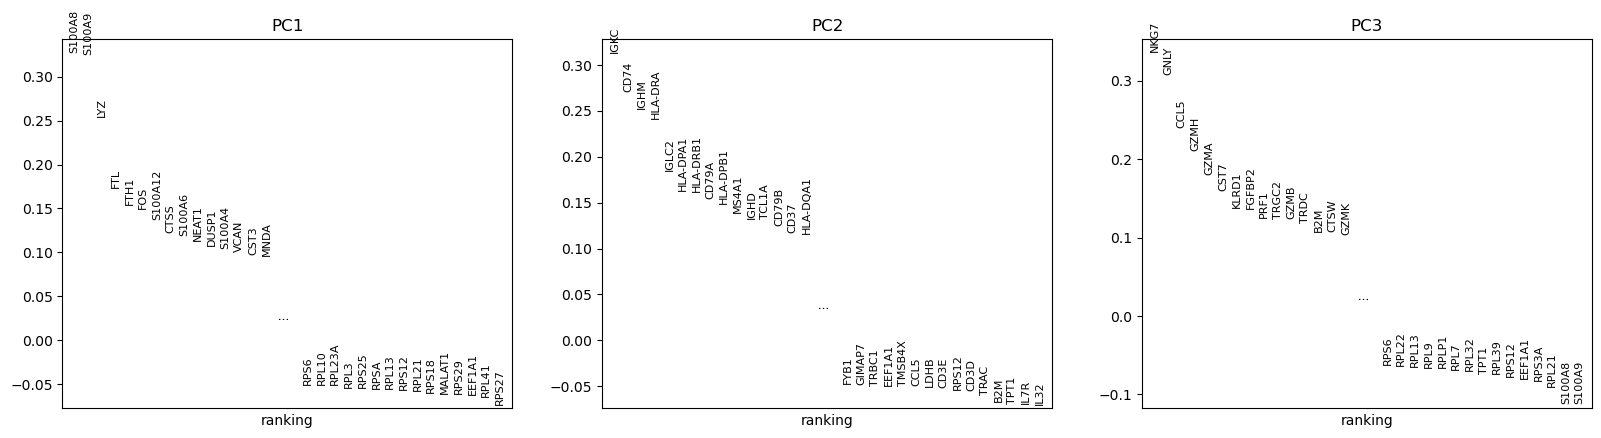

In [29]:
# use scanpy's plotting function pca_loadings to display the loadings of the  first 3 principal components
sc.pl.pca_loadings(adata2, 
                   components=[1, 2, 3], 
                   include_lowest=True
    )

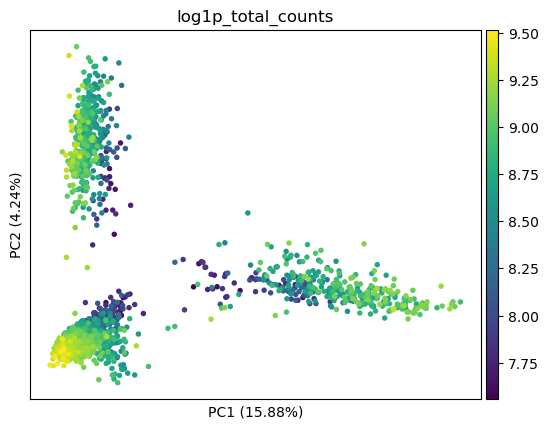

In [30]:
# plot a a 2D scatter plot of the dataset in its first two principal components using 
# scanpy's pca plot function. Colour the points by log1p_total_counts.
# use annotate_var_explained=True
sc.pl.pca(adata2, color='log1p_total_counts', annotate_var_explained=True)

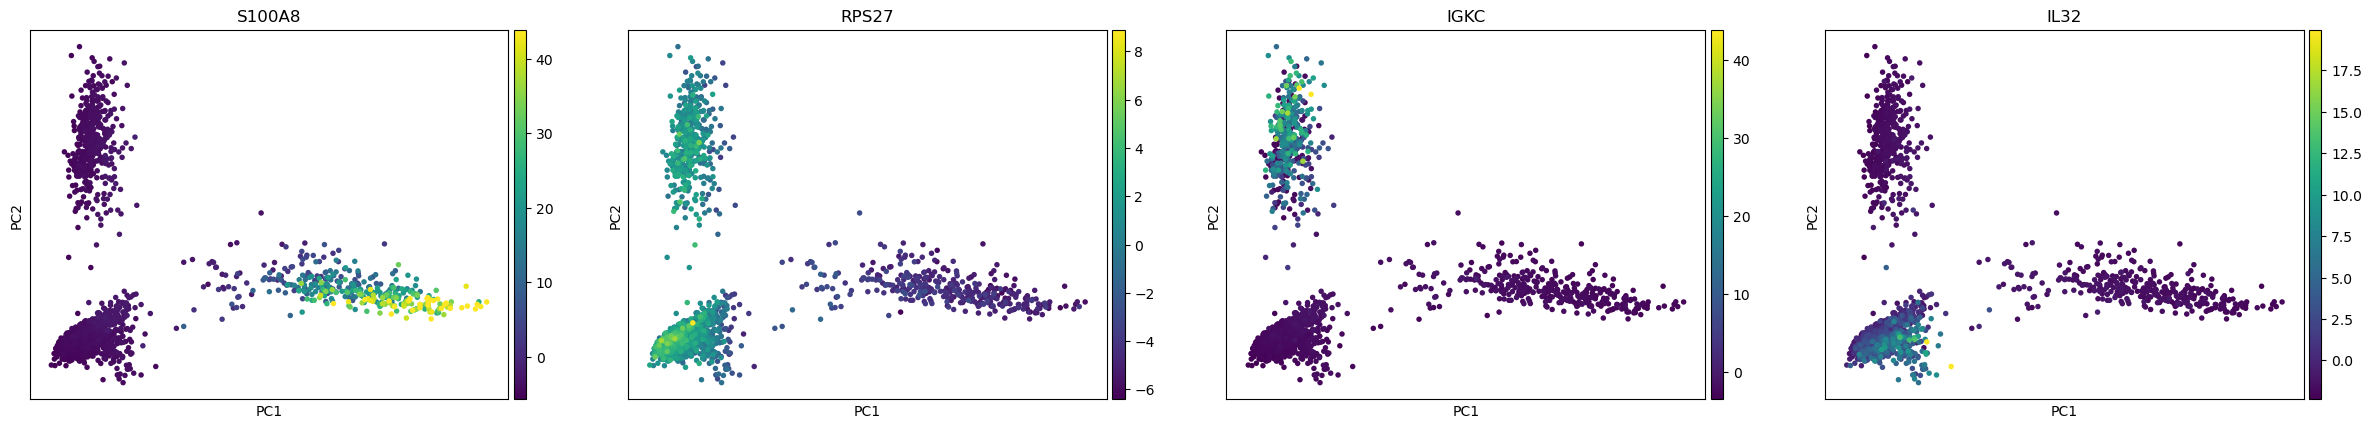

In [31]:
# make the same 2D PCA plot as above, but use the top positive and
# negative loading genes for PCs 1 and 2 to colour the dots
# (should result in 4 panels, one per gene).
sc.pl.pca(adata2, color=['S100A8', 'RPS27', 'IGKC', 'IL32', ])

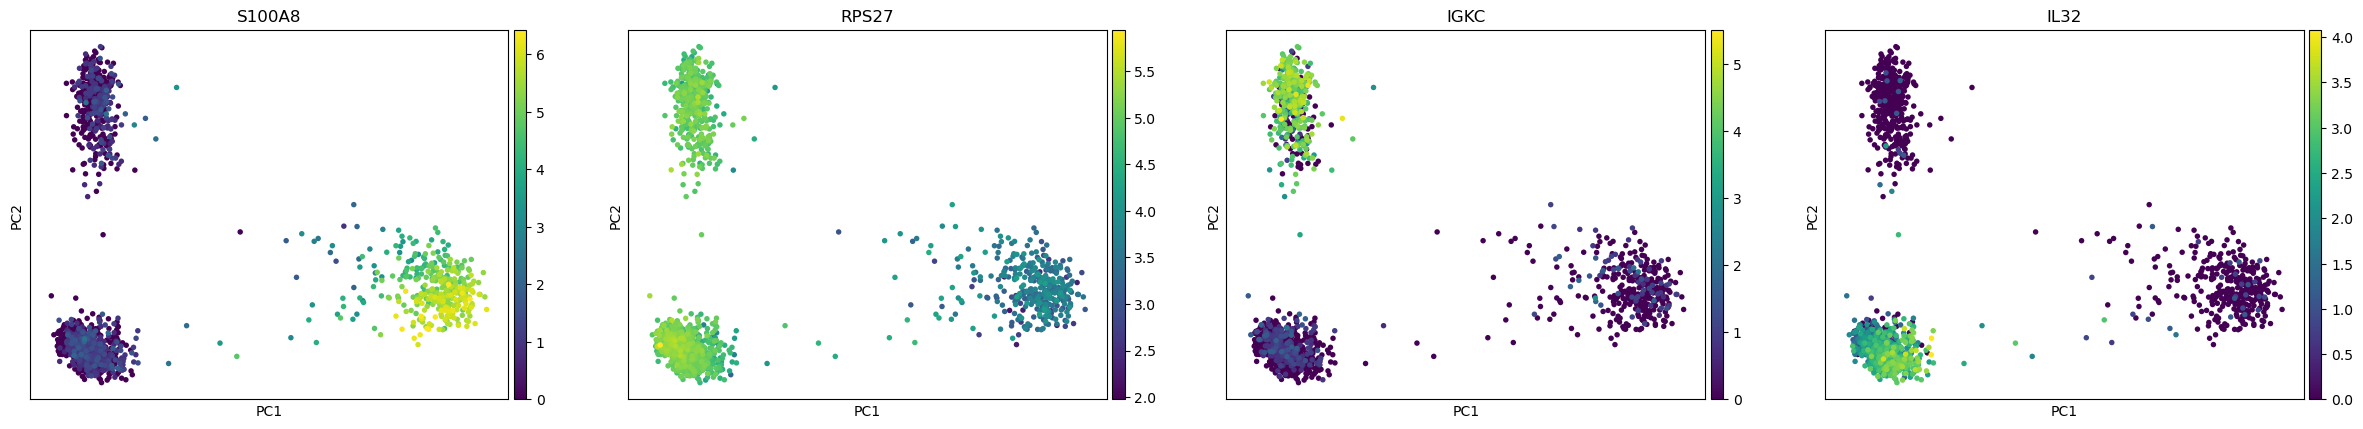

In [32]:
# for a simple comparison, plot the four genes identified above from the Pearson residual analysis
# onto the PCA derived from the lognorm approach (i.e. on object adata)
sc.pl.pca(adata, color=['S100A8', 'RPS27', 'IGKC', 'IL32', ])

The differences between the two normalization methods for our dataset are minor, as is to be expected based on benchmarking work (Ahlmann-Eltze et al., 2023). Interestingly, Pearson residuals here pick up on  ribosomal genes on PC1, a group of genes for which most cells have some expression and the dynamic range in the lognorm approach is not very large (lognormalized expression between 3 and 6). Pearson residuals open up this dynamic range more, resulting in higher weight on PC1. This illustrates how Pearson residues may pick up on more subtle differences compared to standard approaches, but also shows that in most cases (including ours), the extra effort is not necessary.

### Preliminary cell type exploration
The data we are working with contains subtypes of peripheral blood mononuclear cells (some cell types were excluded during the preparation of the example dataset). Find marker genes for potentially included cell types, for example using the Protein Atlas (https://www.proteinatlas.org/humanproteome/immune+cell ), and plot them onto the PCA to check whether they are present.

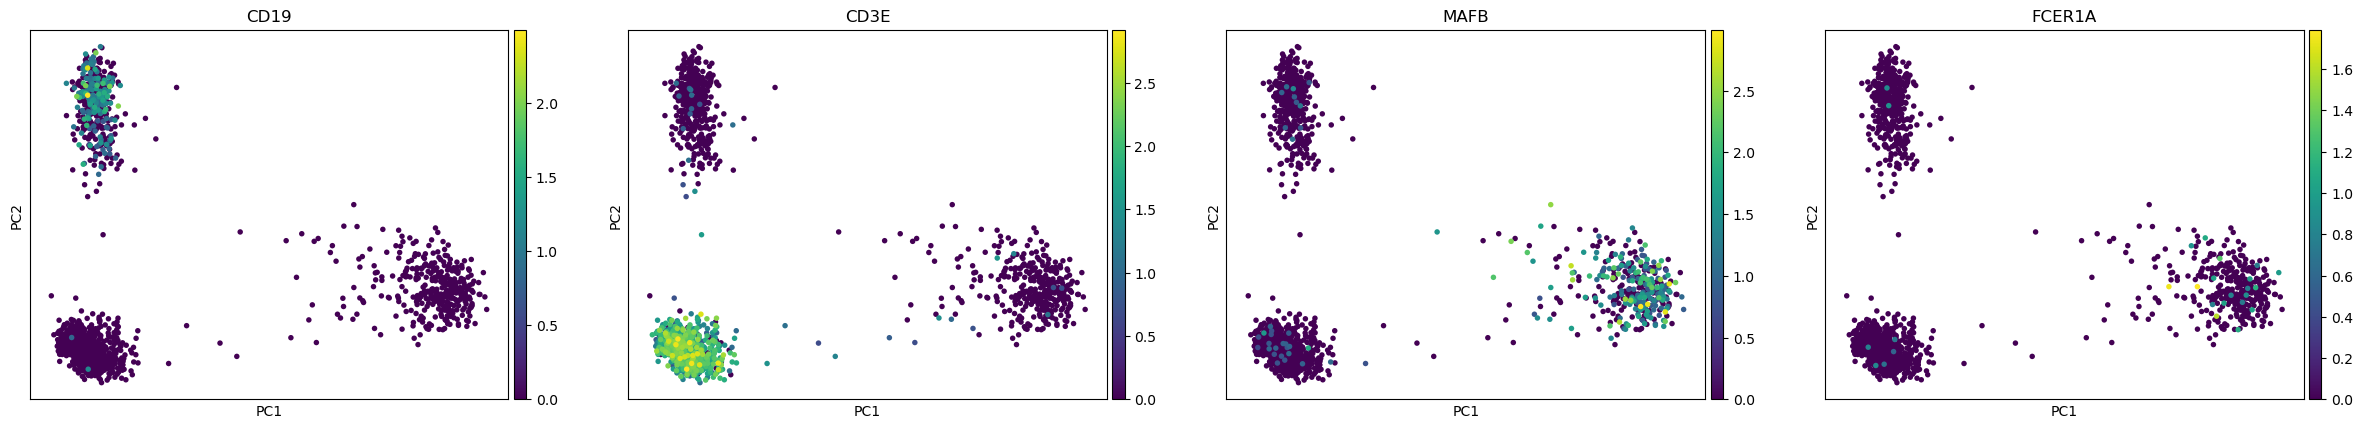

In [33]:
# plot the candidate marker genes you found onto the 2D PCA plot
sc.pl.pca(adata, color=(['CD19', 'CD3E', 'MAFB', 'FCER1A']))

### Non-linear dimension reduction and clustering
Below, we will further reduce the dimensionality of the data by discarding higher PCs, create a UMAP as an example for a non-linear 2D embedding, and use graph-based clustering for community detection.

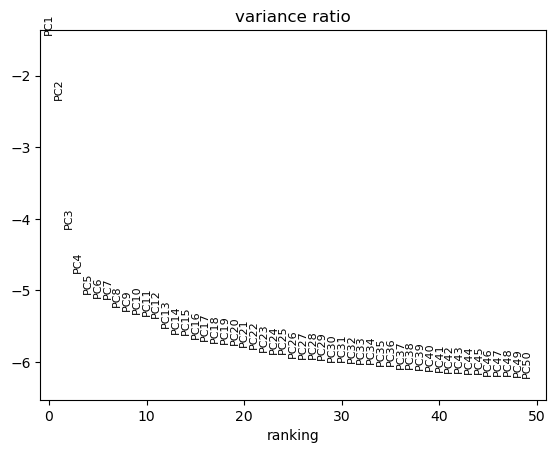

In [34]:
# use the plot function sc.pl.pca_variance_ratio to get a look at
# the variance captured by each PC
# play with using log=True and log=False
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

#### Questions
1. What do we learn from the elbow plot? 
2. Based on the plots as well as on what was discussed during the lecture, how many PCs would you suggest keeping for downstream steps?

In [35]:
# Graph-based clustering and UMAP calculation need a nearest-neighbor graph
# as an input. Calculate the nearest neighbors using scanpy's neighbors function,
# and be sure to specify the number of PCs to consider for this step
sc.pp.neighbors(adata, n_pcs=20)

In [66]:
# next, we calculate a clustering using the Leiden algorithm
# by calling the leiden function.
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)

In [67]:
# calculate a umap embedding using the corresponding scanpy function
sc.tl.umap(adata)

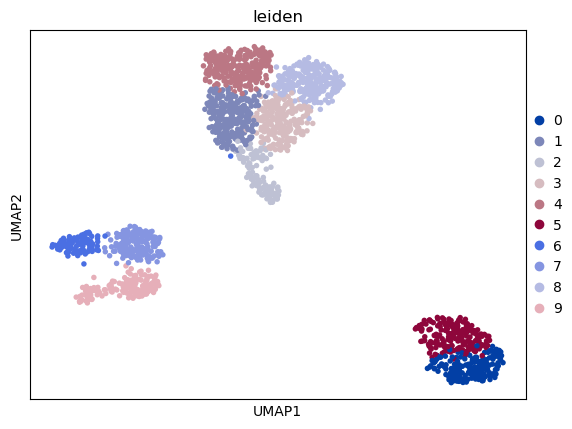

In [68]:
# plot the UMAP coloured by the Leiden clustering returend above
sc.pl.umap(adata, color='leiden')

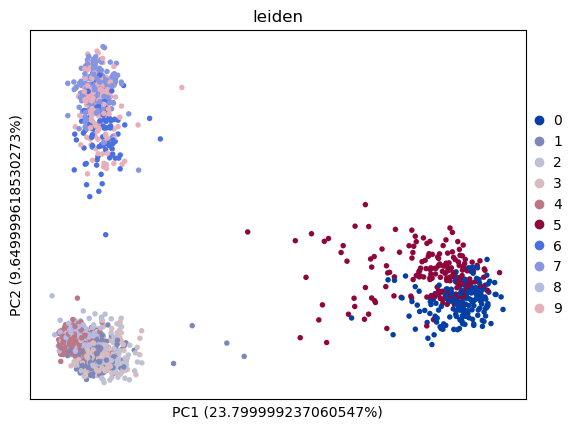

In [69]:
# plot the Leiden clustering onto the PCA calculated above
sc.pl.pca(adata, color='leiden', annotate_var_explained=True)

#### Questions
1. Please describe the UMAP and PCA plots above. What are the main differences?
2. Discuss with your neighbor how you think these differences may arise given that PCA is a linear transformation and UMAP is not, but rather an algorithm optimised to project local similarities in high-dimensional space into 2D.

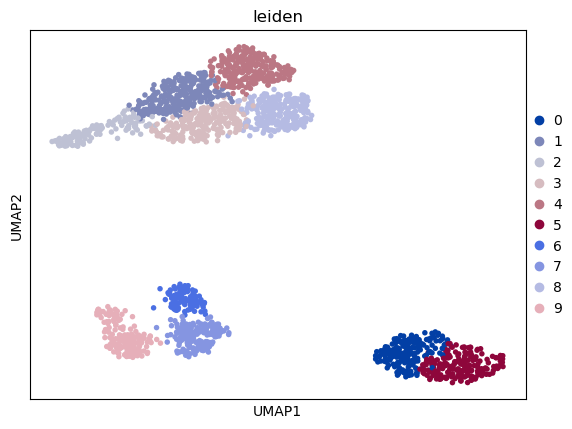

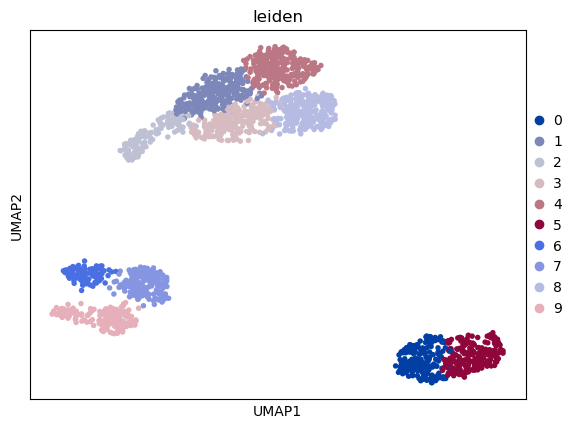

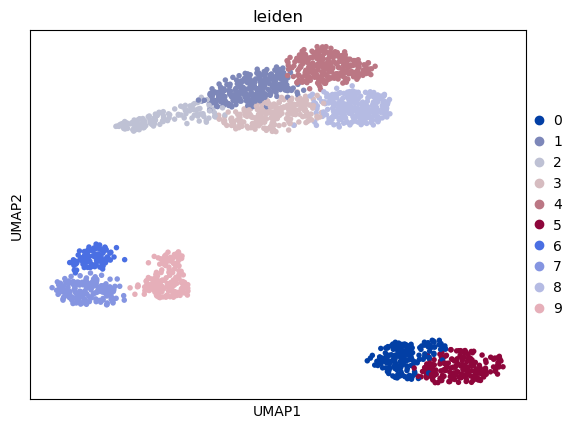

In [70]:
# the UMAP projection algorithm has stochastic elements meaning
# that its outcome depends on random initial assignments of cells. Exlore these random effects
# by running and plotting UMAP three times with different random_state values.
sc.tl.umap(adata, random_state=1)
sc.pl.umap(adata, color='leiden')
plt.show()
sc.tl.umap(adata, random_state=9678453)
sc.pl.umap(adata, color='leiden')
plt.show()
sc.tl.umap(adata, random_state=213)
sc.pl.umap(adata, color='leiden')
plt.show()

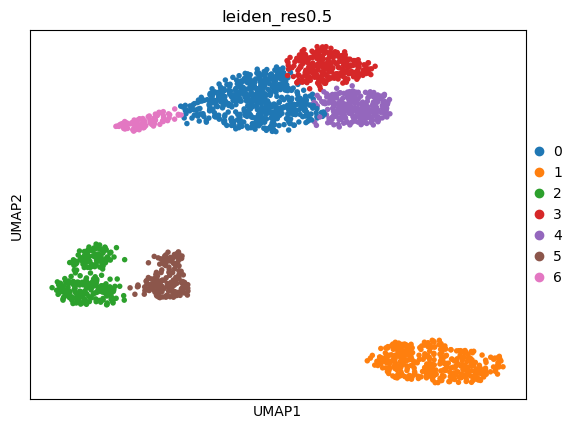

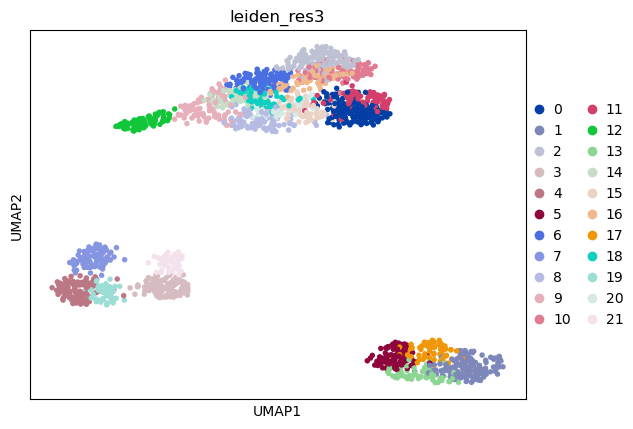

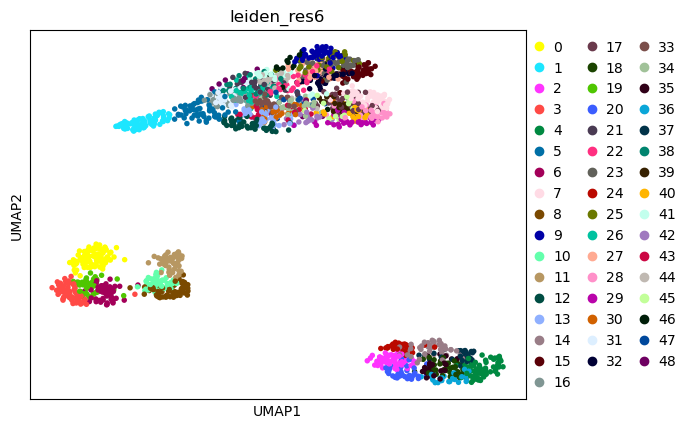

In [72]:
# An important parameter of Leiden clustering is resolution. Run the clustering three
# times with different resolutions and plot the results. You can store each clustering
# outcome by using different name tags using key_added='leiden_res1.0' or similar
sc.tl.leiden(adata, resolution=0.5, key_added='leiden_res0.5')
sc.pl.umap(adata, color='leiden_res0.5')
plt.show()
sc.tl.leiden(adata, resolution=3, key_added='leiden_res3')
sc.pl.umap(adata, color='leiden_res3')
plt.show()
sc.tl.leiden(adata, resolution=6, key_added='leiden_res6')
sc.pl.umap(adata, color='leiden_res6')
plt.show()

#### Questions
1. Which UMAP would you chose for publication?
2. What happens as you change the resolution parameter? With which resolution whould you proceed for further investigation?

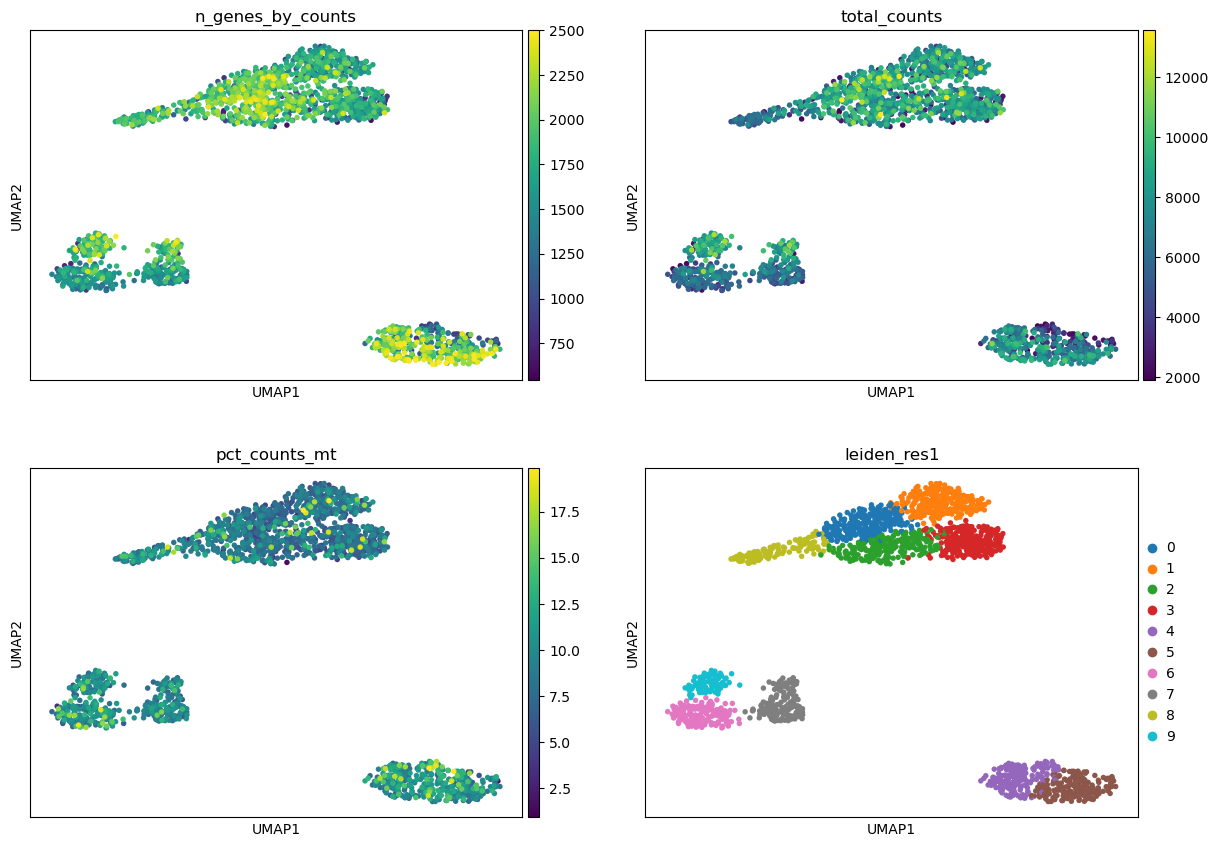

In [74]:
# plot the QC metrics discussed above onto a UMAP plot with 4 panels,
# the fourth showing the clustering in the resolution you intend to
# proceed with
sc.pl.umap(adata, color=["n_genes_by_counts", "total_counts", "pct_counts_mt", "leiden_res1"], ncols=2)

### Marker gene calculation and bottom-up cell type annotation
We will now calculate genes characteristic for each cluster (marker genes) and use them to identify the cell types in our dataset. We will also explore an automed cell type annotation method and compare the results.

In [75]:
# for annotation purposes, select a clustering resolution which results in 6-7 clusters
# then, run marker gene calculations with the rank_genes_groups function
sc.tl.rank_genes_groups(adata, groupby="leiden_res1", method="wilcoxon")

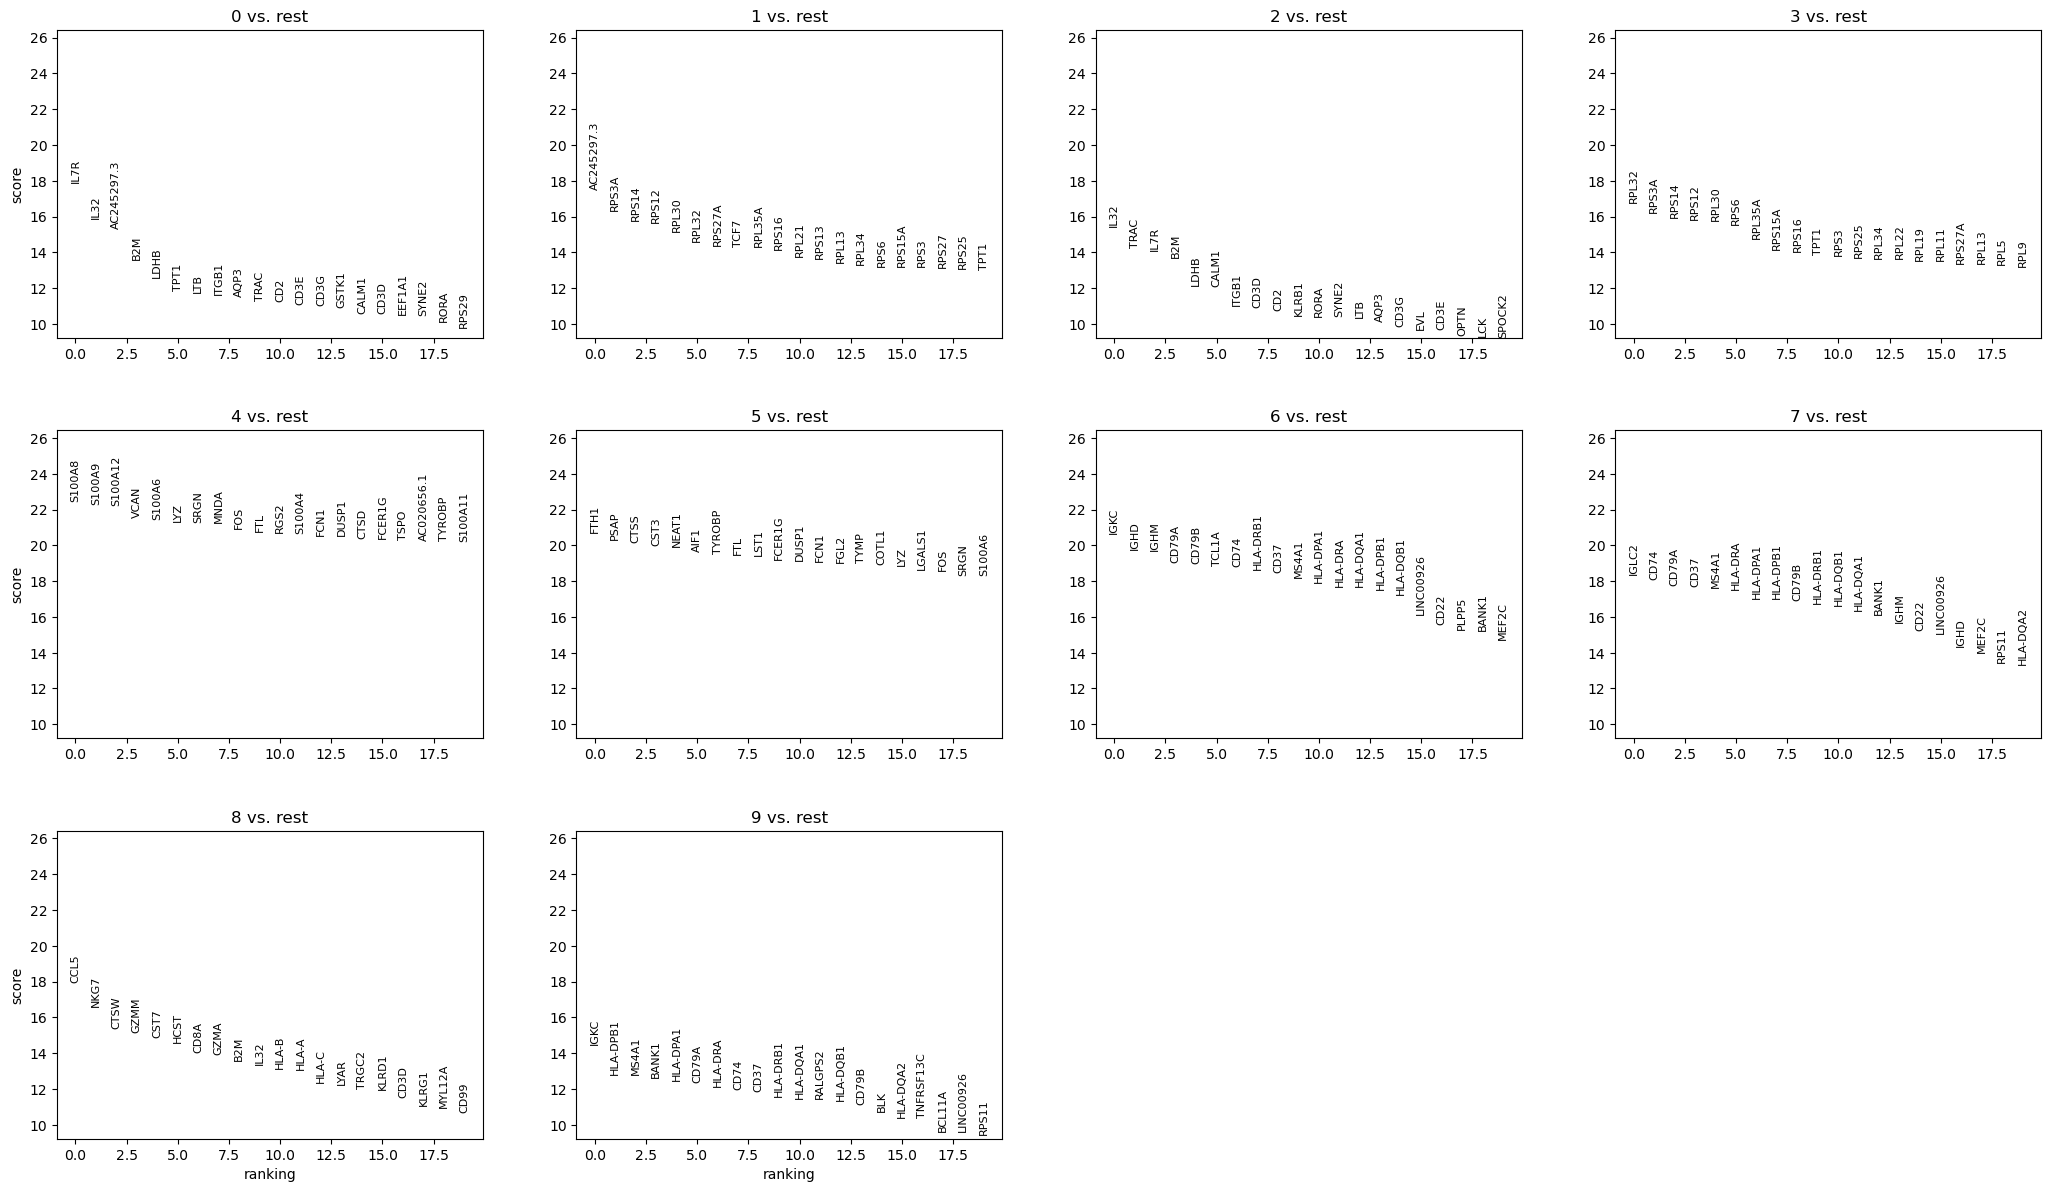

In [76]:
# first, have a look at the top marker genes associated with each cluster
# using the plot function rank_genes_groups
sc.pl.rank_genes_groups(adata)

In [77]:
# you can inspect each groups marker genes using a get function
# as shown below, and by entering the group name you are interested in
sc.get.rank_genes_groups_df(adata, group='0')

names     scores  logfoldchanges         pvals     pvals_adj
0            IL7R  17.869822        2.722020  2.026440e-71  2.917061e-67
1            IL32  15.873334        2.357496  9.695189e-57  6.978113e-53
2      AC245297.3  15.314077        2.741456  6.157962e-53  2.954795e-49
3             B2M  13.605072        0.435483  3.736000e-42  1.344493e-38
4            LDHB  12.592499        1.382312  2.322031e-36  6.685127e-33
...           ...        ...             ...           ...           ...
14390    HLA-DPA1 -10.655067       -3.523402  1.651255e-26  1.251043e-23
14391    HLA-DPB1 -10.724495       -3.368625  7.811297e-27  6.246868e-24
14392    HLA-DRB1 -11.077327       -4.220782  1.616255e-28  1.661857e-25
14393        CD74 -11.141958       -2.514019  7.837676e-29  8.678719e-26
14394     HLA-DRA -11.547371       -3.731866  7.611310e-31  1.217387e-27

[14395 rows x 5 columns]

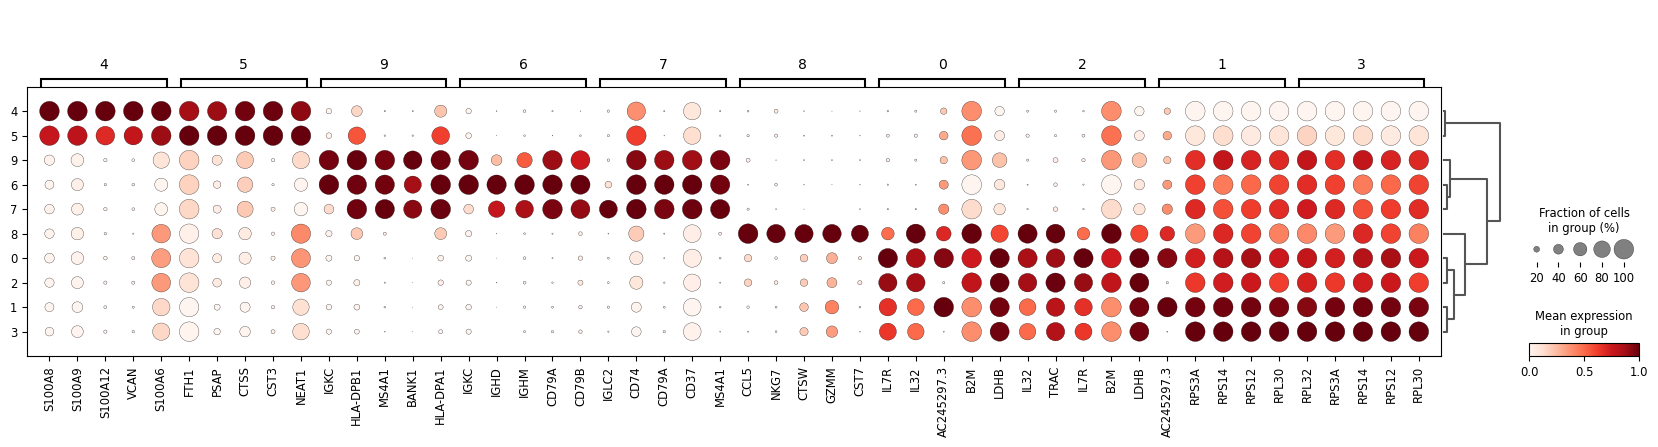

In [78]:
# now, we visualize the top 5 differentially expressed genes per cluster as a dotplot
# using rank_genes_groups_dotplot
# the function automatically calculates and plots a dendrogram showing similarity between
# cell types
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden_res1", standard_scale="var", n_genes=5
)

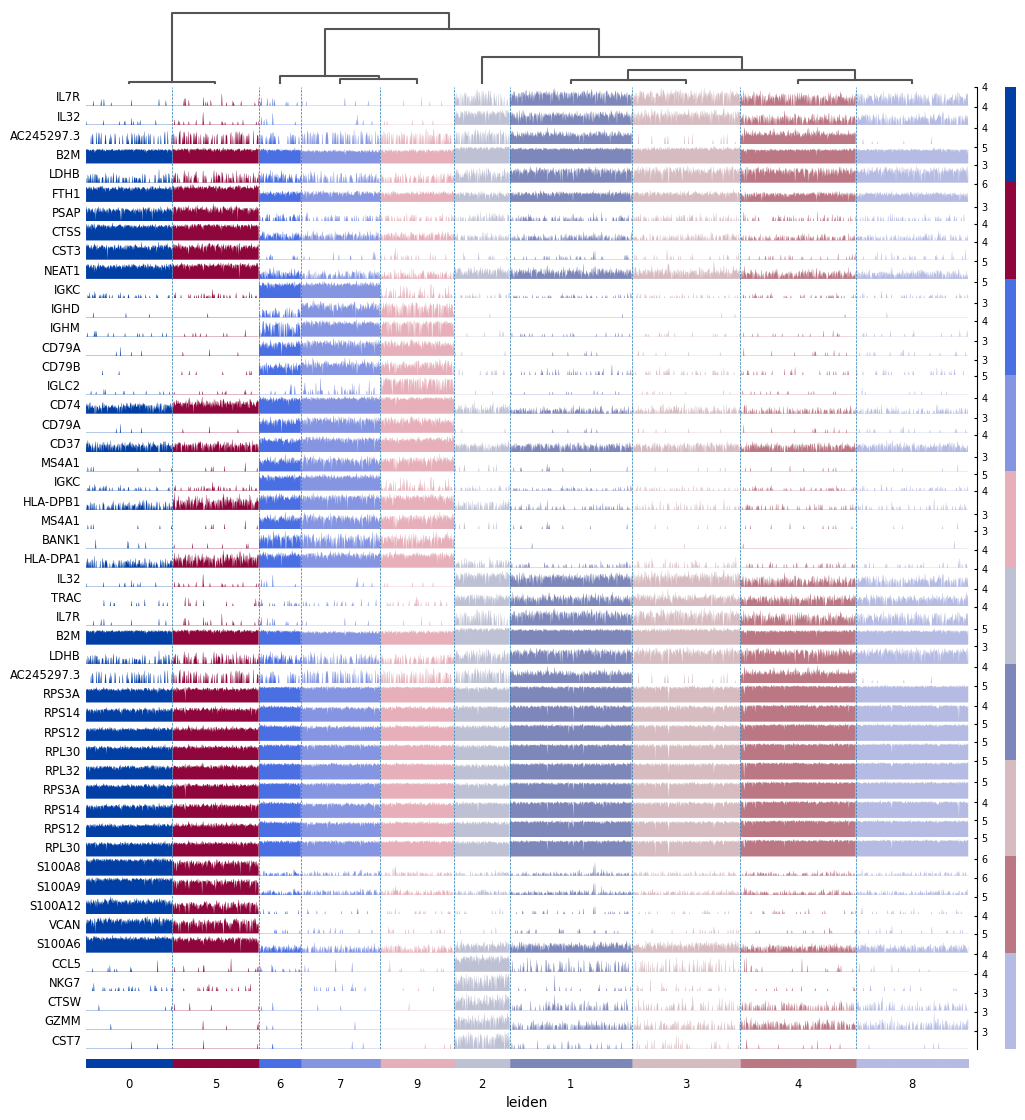

In [79]:
# scanpy offers other types of plots for marker gene analysis. Have a look at the
# corresponding documentation and try another 1-2 types of plots, e.g. the tracksplot,
# which helps you visualize expression across individual cells
# https://scanpy-tutorials.readthedocs.io/en/multiomics/visualizing-marker-genes.html
ax = sc.pl.rank_genes_groups_tracksplot(adata, n_genes=5, groupby='leiden')

#### Questions
1. What do positive and negative fold changes in the marker gene table mean?
2. Why is there a p-value and an adjusted p-value?
3. What does the dendrogramm on the side of the dot plot tell us? Are there any pairs of clusters which seem very similar to each other based on the dendrogramm?
4. Use the marker genes derived for each group and the human protein atlas (https://www.proteinatlas.org/humanproteome/immune+cell) or other resources of your choice to give cell type labels to each cluster.

In [80]:
# if there are clusters for which you are not sure yet, it can help to compare them
# to a neighboring population specifically using rank_genes_groups with the additional
# keys groups=['0', '1'], reference='2' which would compare groups 0 and 1 to group 2


#### Cell-type annotation using marker gene lists (from literature)
Typically, you know which tissue you are analysing and can also find annoated datasets of the same type or even published marker gene lists for your tissue. You can use these to help you annotate your cell types. Search the web for a few marker genes for each of the cell types below and plot these for your clusters.

In [87]:
PBMC_marker_genes = {
    "Classical Monocytes": ["FCN1", "CD14"],
    "B cells": ["IGHD", "IGHM", "TCL1A", "FCER2", "IGHG1", "IGHG2"],
    "CD4+ T": ["CD4", "IL7R", "TRBC2"],
    "CD8+ T": ["CD8A", "CD8B", "GZMK", "GZMA", "CCL5", "GZMB", "GZMH", "GZMA"]}

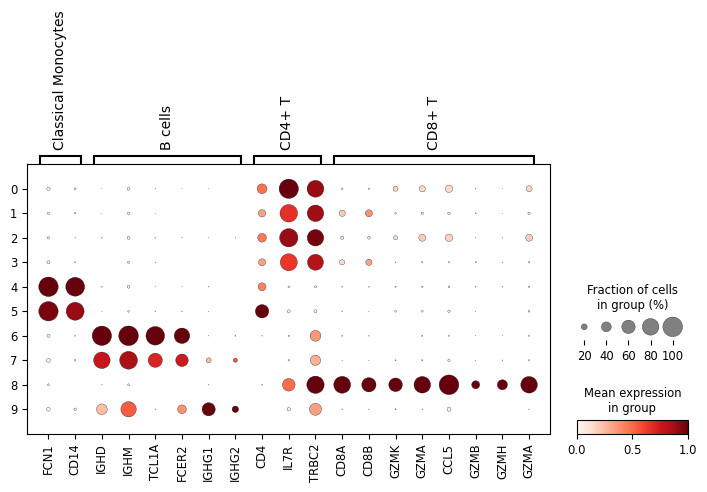

In [88]:
sc.pl.dotplot(adata, PBMC_marker_genes, groupby="leiden_res1", standard_scale="var")

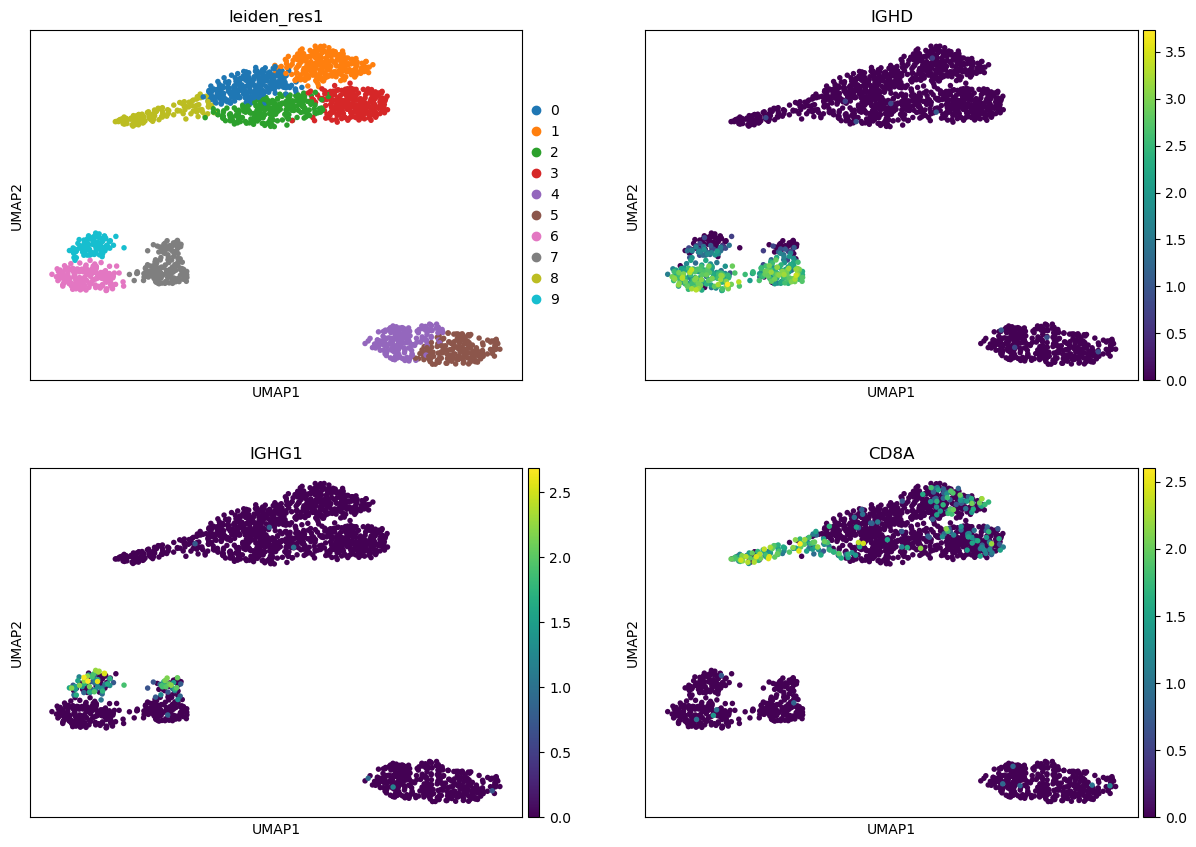

In [94]:
# you can also visualise these markers onto your umap, try it with a few genes
# next to the clustering
sc.pl.umap(adata, color=["leiden_res1", "IGHD", "IGHG1", "CD8A"], ncols=2)

In [97]:
# based on the two annotation approaches above, give a cell type label to every cluster.
# fill the dictionary below according to your needs
mapping_dict = {
    '0': 'strawberries',
    '1': 'blackberries', 
    '2': 'raisins',
    '3': 'smarties',
    '4': 'bertie botts \n beans',
    '5': 'MAOAM',
    '6': 'gummi bears',
    '7': 'blueberries',
    '8': 'raspberries',
    '9': 'grapes'
}
adata.obs['cell_type'] = adata.obs['leiden_res1'].map(mapping_dict).astype('category')

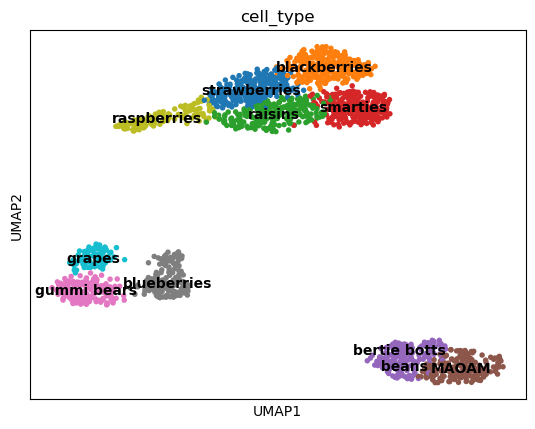

In [98]:
# plot a umap with cell type labels on top of each cluster
sc.pl.umap(adata, color='cell_type', legend_loc='on data')

#### Questions
1. Did your chosen clustering resolution make sense? Were there some clusters which you would combine (annotate with the same label), or, conversely, clusters which you would like to split and analyse in more depth?

### Automated cell type annotation
There are several packages available for automated cell type annotation. One option is `celltypist` which comes as a as a python package, command line tool or webservice https://www.celltypist.org/. Online analysis accepts a .csv file, which contains an expression matrix with cells as rows and gene symbols as columns (or the opposite). A raw count matrix is expected. We will generate the file, upload it, and compare their results to ours in this section.

In [99]:
# we will first put the required data into a dataframe and then export to csv
celltypist_df = pd.DataFrame(data=adata.layers['counts'].todense(), index=adata.obs_names, columns=adata.var_names)
celltypist_df.to_csv('celltypist_input.csv')

Now, please go to the celltypist website and upload your file (should be around 100MB), hopefully the WiFi will be with us on this. After submitting the query, you will receive an email when the results are availabel for download (typically quite fast). In case you encounter problems with the data upload, you can also take pre-generated celltypist results in the `materials/Day3`section of the course github.

In [102]:
# import the results and match them to the dataframe
celltypist_results = pd.read_csv('../Day3/celltypist_predicted_labels.csv', index_col=0)
# inspect :)
celltypist_results

predicted_labels  over_clustering  \
AAACGAAAGACGTCGA-1        Classical monocytes               16   
AAAGAACAGTTCCGTA-1   Tcm/Naive helper T cells               45   
AAAGAACGTTTGTTGG-1   Tcm/Naive helper T cells               24   
AAAGGATGTGTGGTCC-1        Classical monocytes               47   
AAAGGATTCTGCGGGT-1  Tem/Trm cytotoxic T cells               10   
...                                       ...              ...   
TTTGGAGGTCAAGCCC-1        Classical monocytes               44   
TTTGGAGTCTCGACGG-1              Naive B cells               20   
TTTGGTTAGGACACTG-1        Classical monocytes               44   
TTTGGTTTCCTCCACA-1   Tcm/Naive helper T cells               11   
TTTGTTGTCCAAGCCG-1   Tcm/Naive helper T cells                3   

                              majority_voting  
AAACGAAAGACGTCGA-1        Classical monocytes  
AAAGAACAGTTCCGTA-1   Tcm/Naive helper T cells  
AAAGAACGTTTGTTGG-1   Tcm/Naive helper T cells  
AAAGGATGTGTGGTCC-1        Classical monocytes  
AAAGGATTCTGCGGGT-1  Tem/Trm cytotoxic T cells  
...                                       ...  
TTTGGAGGTCAAGCCC-1        Classical monocytes  
TTTGGAGTCTCGACGG-1              Naive B cells  
TTTGGTTAGGACACTG-1        Classical monocytes  
TTTGGTTTCCTCCACA-1   Tcm/Naive helper T cells  
TTTGTTGTCCAAGCCG-1   Tcm/Naive helper T cells  

[1923 rows x 3 columns]

In [103]:
# add the results to the anndata object
adata.obs['celltypist'] = celltypist_results['predicted_labels']

... storing 'celltypist' as categorical


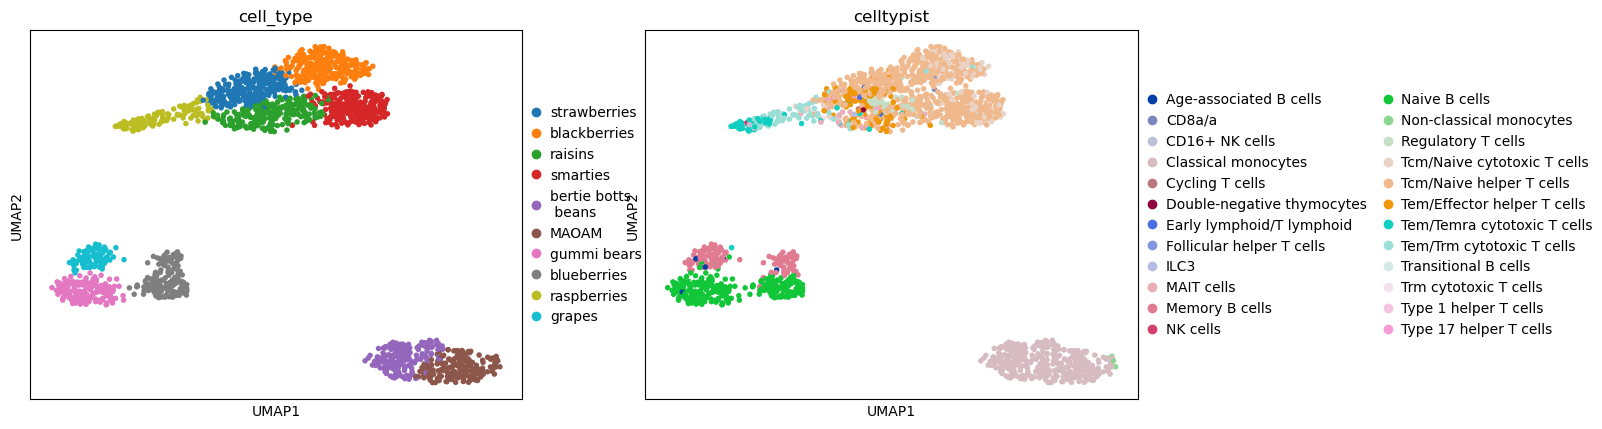

In [104]:
# plot two UMAPS, one with your annotation and the other with the celltypist label as a color code
sc.pl.umap(adata, color=['cell_type', 'celltypist'])

#### Questions
1. How does your annotation compare to celltypist? Are there any differences? Who is right?
2. What is the difference between celltypist outputs 'predicted_labels' and 'majority_voting'?
3. There seem to be two populations each of naive and memory B cells. What is the difference between them?
4. If you have the time, run the processing steps neighbors/leiden/umap on the object normalized with Pearson residuals (adata2). Does the split still appear? Which data analysis strategy is better?